# Task 2


# Task 2.1

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

np.random.seed(11) #seed

## 1. Generación de Datos

### 1.a
Vamos a generar 1000 puntos basados en la función: $y = 2x^3 - 3x^2 + 5x + 3$

### 1.b
Luego agregaremos ruido gaussiano y normalizaremos los datos.

In [28]:
def generate_polynomial_data(n_samples: int = 1000, noise_std: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
    # Generar valores de x en el rango [-2, 2]
    X = np.random.uniform(-2, 2, n_samples)
    
    # Calcular y usando la función polinomial: y = 2x³ - 3x² + 5x + 3
    y_true = 2 * X**3 - 3 * X**2 + 5 * X + 3
    
    # Agregar ruido aleatorio normal (gaussiano)
    noise = np.random.normal(0, noise_std, n_samples)
    y = y_true + noise
    
    return X, y

# Generar los datos
X_raw, y_raw = generate_polynomial_data(n_samples=1000, noise_std=2.0)

print(f"Datos generados:")
print(f"    Número de muestras: {len(X_raw)}")
print(f"    Rango de X: [{X_raw.min():.2f}, {X_raw.max():.2f}]")
print(f"    Rango de y: [{y_raw.min():.2f}, {y_raw.max():.2f}]")

Datos generados:
    Número de muestras: 1000
    Rango de X: [-1.99, 1.99]
    Rango de y: [-35.49, 19.04]


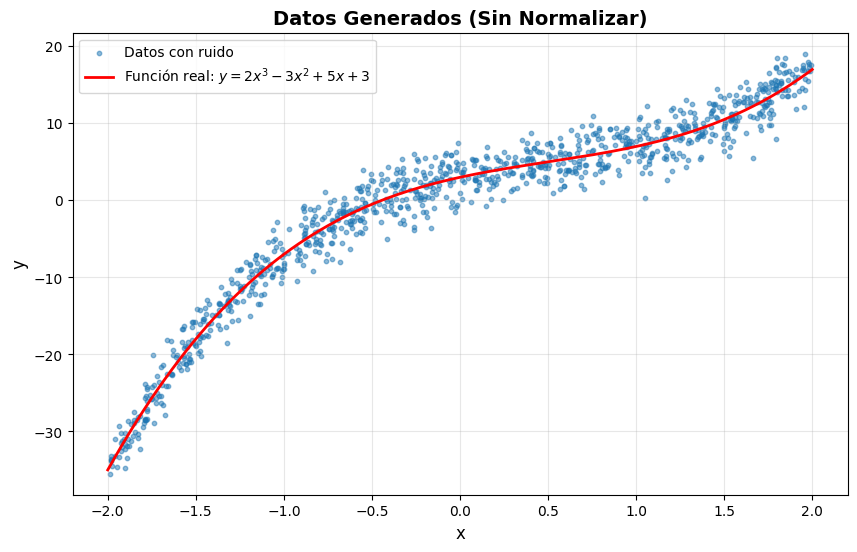

In [29]:
# Visualizar los datos generados
plt.figure(figsize=(10, 6))
plt.scatter(X_raw, y_raw, alpha=0.5, s=10, label='Datos con ruido')

# Graficar la función verdadera
X_true = np.linspace(-2, 2, 200)
y_true = 2 * X_true**3 - 3 * X_true**2 + 5 * X_true + 3
plt.plot(X_true, y_true, 'r-', linewidth=2, label='Función real: $y = 2x^3 - 3x^2 + 5x + 3$')

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Datos Generados (Sin Normalizar)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 1.c. Normalizacion de los datos
Usaremos Z-score normalization: $z = \frac{x - \mu}{\sigma}$

donde $\mu$ es la media y $\sigma$ es la desviación estándar.

In [30]:
def normalize_data(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, dict]:
    # Calcular media y desviación estándar
    X_mean = np.mean(X)
    X_std = np.std(X)
    y_mean = np.mean(y)
    y_std = np.std(y)
    
    # Normalizar
    X_norm = (X - X_mean) / X_std
    y_norm = (y - y_mean) / y_std
    
    # Guardar estadísticas para desnormalizar después si es necesario
    stats = {
        'X_mean': X_mean,
        'X_std': X_std,
        'y_mean': y_mean,
        'y_std': y_std
    }
    
    return X_norm, y_norm, stats

# Normalizar los datos
X_norm, y_norm, normalization_stats = normalize_data(X_raw, y_raw)

print("Datos normalizados:")
print(f"    X normalizado: media = {X_norm.mean():.6f}, std = {X_norm.std():.6f}")
print(f"    y normalizado: media = {y_norm.mean():.6f}, std = {y_norm.std():.6f}")
print(f"\nEstadísticas de normalización:")
for key, value in normalization_stats.items():
    print(f"    {key}: {value:.4f}")

Datos normalizados:
    X normalizado: media = 0.000000, std = 1.000000
    y normalizado: media = -0.000000, std = 1.000000

Estadísticas de normalización:
    X_mean: 0.0300
    X_std: 1.1466
    y_mean: -0.5162
    y_std: 11.9496


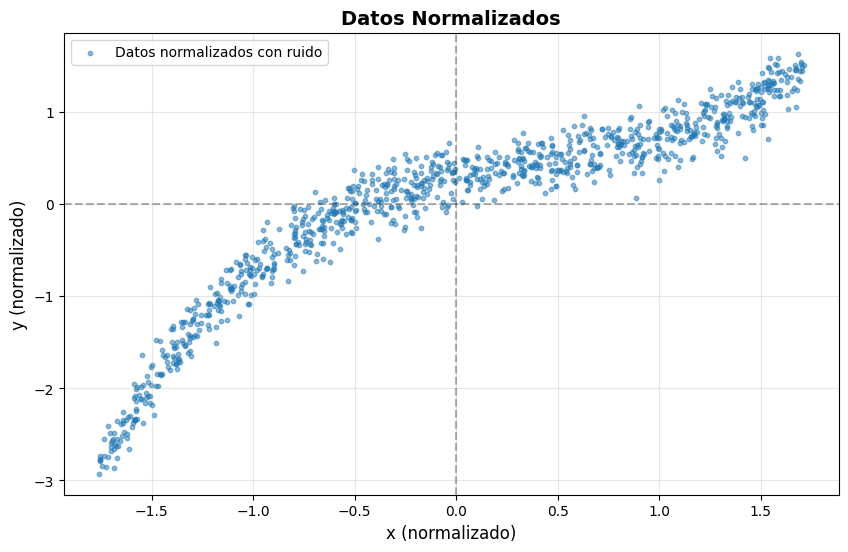

In [31]:
# Visualizar datos normalizados
plt.figure(figsize=(10, 6))
plt.scatter(X_norm, y_norm, alpha=0.5, s=10, label='Datos normalizados con ruido')
plt.xlabel('x (normalizado)', fontsize=12)
plt.ylabel('y (normalizado)', fontsize=12)
plt.title('Datos Normalizados', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.show()

## 2. Implementacion de Algoritmos

### Algoritmos de Descenso de Gradiente

Modelo polinomial: $\hat{y} = w_0 + w_1 x + w_2 x^2 + w_3 x^3$

Función de pérdida (MSE): $L(w) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$

Gradiente: $\nabla L = \frac{\partial L}{\partial w}$

#### Funciones Auxiliares
Funciones para calcular predicciones, pérdida y gradientes.

In [32]:
def create_polynomial_features(X: np.ndarray, degree: int = 3) -> np.ndarray: #Crea matriz de features polinomiales
    n_samples = len(X)
    X_poly = np.zeros((n_samples, degree + 1))
    
    # Crear features: [1, x, x², x³, ...]
    for i in range(degree + 1):
        X_poly[:, i] = X ** i
    
    return X_poly #Matriz de features


def predict(X_poly: np.ndarray, weights: np.ndarray) -> np.ndarray: # Calcula predicciones usando el modelo polinomial.
    return X_poly @ weights #predicciones


def compute_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float: # Calcula el Mean Squared Error (MSE).
    n_samples = len(y_true)
    return (1 / n_samples) * np.sum((y_true - y_pred) ** 2) # loss


def compute_gradient(X_poly: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray: # Calcula el gradiente de la función de pérdida MSE.
    n_samples = len(y_true)
    # Gradiente: -(2/N) * X.T @ (y - ŷ)
    gradient = -(2 / n_samples) * X_poly.T @ (y_true - y_pred)
    return gradient #  Vector gradiente

In [33]:
# Crear features polinomiales para nuestros datos
X_poly = create_polynomial_features(X_norm, degree=3)

print(f"Shape de X_poly: {X_poly.shape}")
print(f"\nColumnas: [1, x, x², x³]")
print(X_poly[:5]) # primeras 5 filas

Shape de X_poly: (1000, 4)

Columnas: [1, x, x², x³]
[[ 1.00000000e+00 -1.14156780e+00  1.30317704e+00 -1.48766494e+00]
 [ 1.00000000e+00 -1.70252005e+00  2.89857454e+00 -4.93488128e+00]
 [ 1.00000000e+00 -1.54464131e-01  2.38591678e-02 -3.68538562e-03]
 [ 1.00000000e+00  7.58563949e-01  5.75419265e-01  4.36492310e-01]
 [ 1.00000000e+00 -3.04527257e-01  9.27368505e-02 -2.82408988e-02]]


### 2.a Batch Gradient Descent

Algoritmo:
1. Calcular predicciones con todos los datos: $\hat{y} = X_{poly} \cdot w$
2. Calcular gradiente con todos los datos: $\nabla L = -(2/N) \cdot X_{poly}^T \cdot (y - \hat{y})$
3. Actualizar pesos: $w = w - \eta \cdot \nabla L$

In [34]:
def batch_gradient_descent( #Usa todos los datos en cada paso
    X_poly: np.ndarray, # Matriz de features polinomiales
    y: np.ndarray, # Vector de targets
    learning_rate: float = 0.01, # Tasa de aprendizaje η
    n_epochs: int = 100, # Número de épocas
    verbose: bool = True # Si mostrar progreso
) -> Tuple[np.ndarray, list, list]:

    import time
    
    # Inicializar pesos aleatoriamente
    n_features = X_poly.shape[1]
    weights = np.random.randn(n_features) * 0.01
    
    loss_history = []
    time_history = []
    
    start_time = time.time()
    
    for epoch in range(n_epochs):
        # 1. Calcular predicciones usando TODOS los datos
        y_pred = predict(X_poly, weights)
        
        # 2. Calcular pérdida
        loss = compute_loss(y, y_pred)
        
        # 3. Calcular gradiente usando TODOS los datos
        gradient = compute_gradient(X_poly, y, y_pred)
        
        # 4. Actualizar pesos: w = w - η·∇L
        weights = weights - learning_rate * gradient
        
        # Guardar métricas
        current_time = time.time() - start_time
        loss_history.append(loss)
        time_history.append(current_time)
        
        if verbose and (epoch % 10 == 0 or epoch == n_epochs - 1):
            print(f"Epoch {epoch:3d}/{n_epochs} | Loss: {loss:.6f} | Time: {current_time:.4f}s")
    
    return weights, loss_history, time_history #  Pesos finales del modelo, Historia de pérdidas, Tiempos acumulados


print("Función Batch Gradient Descent")

Función Batch Gradient Descent


### 2.b Stochastic Gradient Descent (SGD)

Algoritmo:
1. Para cada época:
   - Mezclar los datos aleatoriamente
   - Para cada muestra individual $i$:
     - Calcular predicción: $\hat{y}_i = x_i \cdot w$
     - Calcular gradiente con esa muestra: $\nabla L_i = -2 \cdot x_i \cdot (y_i - \hat{y}_i)$
     - Actualizar pesos: $w = w - \eta \cdot \nabla L_i$

In [35]:
def stochastic_gradient_descent( # SGD usa 1 muestra aleatoria en cada iteración para calcular el gradiente.
    X_poly: np.ndarray, # Matriz de features polinomiales
    y: np.ndarray, # Vector de targets
    learning_rate: float = 0.01, # Tasa de aprendizaje
    n_epochs: int = 100, # Número de épocas
    verbose: bool = True # Si mostrar progreso
) -> Tuple[np.ndarray, list, list]:

    import time
    
    # Inicializar pesos aleatoriamente
    n_features = X_poly.shape[1]
    n_samples = len(y)
    weights = np.random.randn(n_features) * 0.01
    
    loss_history = []
    time_history = []
    
    start_time = time.time()
    
    for epoch in range(n_epochs):
        # Mezclar los índices para procesamiento aleatorio
        indices = np.random.permutation(n_samples)
        
        # Procesar cada muestra individualmente
        for i in indices:
            # 1. Obtener UNA muestra
            X_i = X_poly[i:i+1]  # Shape: (1, n_features)
            y_i = y[i:i+1]        # Shape: (1,)
            
            # 2. Calcular predicción para esta muestra
            y_pred_i = predict(X_i, weights)
            
            # 3. Calcular gradiente usando solo esta muestra
            # ∇L_i = -2 * X_i.T @ (y_i - ŷ_i)
            gradient = compute_gradient(X_i, y_i, y_pred_i)
            
            # 4. Actualizar pesos: w = w - η·∇L_i
            weights = weights - learning_rate * gradient
        
        # Calcular pérdida total al final de cada época (para comparación)
        y_pred_all = predict(X_poly, weights)
        loss = compute_loss(y, y_pred_all)
        
        # Guardar métricas
        current_time = time.time() - start_time
        loss_history.append(loss)
        time_history.append(current_time)
        
        if verbose and (epoch % 10 == 0 or epoch == n_epochs - 1):
            print(f"Epoch {epoch:3d}/{n_epochs} | Loss: {loss:.6f} | Time: {current_time:.4f}s")
    
    return weights, loss_history, time_history #  Pesos finales del modelo, Historia de pérdidas, Tiempos acumulados


print("Función Stochastic Gradient Descent")

Función Stochastic Gradient Descent


### 2.c Mini-batch Gradient Descent

Algoritmo:
1. Para cada época:
   - Mezclar los datos aleatoriamente
   - Dividir en lotes de tamaño n
   - Para cada lote:
     - Calcular predicción: $\hat{y}_{batch} = X_{batch} \cdot w$
     - Calcular gradiente del lote: $\nabla L_{batch} = -(2/batch\_size) \cdot X_{batch}^T \cdot (y_{batch} - \hat{y}_{batch})$
     - Actualizar pesos: $w = w - \eta \cdot \nabla L_{batch}$

In [36]:
def minibatch_gradient_descent( # Mini-batch Gradient Descent usa un lote de n muestras
    X_poly: np.ndarray, # Matriz de features polinomiales
    y: np.ndarray, # Vector de targets
    learning_rate: float = 0.01, # Tasa de aprendizaje
    batch_size: int = 32, # Tamaño del lote
    n_epochs: int = 100, # Número de épocas
    verbose: bool = True # Si mostrar progreso
) -> Tuple[np.ndarray, list, list]:

    import time
    
    # Inicializar pesos aleatoriamente
    n_features = X_poly.shape[1]
    n_samples = len(y)
    weights = np.random.randn(n_features) * 0.01
    
    loss_history = []
    time_history = []
    
    start_time = time.time()
    
    for epoch in range(n_epochs):
        # Mezclar los datos al inicio de cada época
        indices = np.random.permutation(n_samples)
        X_shuffled = X_poly[indices]
        y_shuffled = y[indices]
        
        # Procesar por mini-batches
        for i in range(0, n_samples, batch_size):
            # 1. Obtener un LOTE de datos
            batch_end = min(i + batch_size, n_samples)
            X_batch = X_shuffled[i:batch_end]
            y_batch = y_shuffled[i:batch_end]
            
            # 2. Calcular predicciones para este lote
            y_pred_batch = predict(X_batch, weights)
            
            # 3. Calcular gradiente usando el LOTE
            # ∇L_batch = -(2/batch_size) * X_batch.T @ (y_batch - ŷ_batch)
            gradient = compute_gradient(X_batch, y_batch, y_pred_batch)
            
            # 4. Actualizar pesos: w = w - η·∇L_batch
            weights = weights - learning_rate * gradient
        
        # Calcular pérdida total al final de cada época (para comparación)
        y_pred_all = predict(X_poly, weights)
        loss = compute_loss(y, y_pred_all)
        
        # Guardar métricas
        current_time = time.time() - start_time
        loss_history.append(loss)
        time_history.append(current_time)
        
        if verbose and (epoch % 10 == 0 or epoch == n_epochs - 1):
            print(f"Epoch {epoch:3d}/{n_epochs} | Loss: {loss:.6f} | Time: {current_time:.4f}s")
    
    return weights, loss_history, time_history # Pesos finales del modelo, Historia de pérdidas, Tiempos acumulados


print("Función Mini-batch Gradient Descent")

Función Mini-batch Gradient Descent


## 3. Experimentación y Análisis

### 3.a Entrenar los tres modelos

SGD actualiza pesos con 1 sola muestra → gradiente muy ruidoso → si usamos LR alto (0.1), los pesos explotan a ±∞.

Esto es normal en la práctica: SGD siempre usa learning rates más pequeños que Batch GD.

In [37]:
# Hiperparámetros
LR_BATCH = 0.1        # Batch puede usar LR alto (gradiente preciso)
LR_MINIBATCH = 0.05   # Mini-batch usa LR medio (algo de ruido)
LR_SGD = 0.01         # SGD necesita LR bajo (muy ruidoso)

N_EPOCHS = 500
BATCH_SIZE = 32

print(f"\nHiperparámetros:")
print(f"    Épocas: {N_EPOCHS}")
print(f"    Batch Size (Mini-batch): {BATCH_SIZE}")
print(f"    Total de datos: {len(X_norm)}")
print(f"\nLearning Rates ajustados por algoritmo:")
print(f"    Batch GD:      η = {LR_BATCH} (gradiente preciso)")
print(f"    Mini-batch GD: η = {LR_MINIBATCH} (gradiente con ruido moderado)")
print(f"    SGD:           η = {LR_SGD} (gradiente muy ruidoso)")
print()


Hiperparámetros:
    Épocas: 500
    Batch Size (Mini-batch): 32
    Total de datos: 1000

Learning Rates ajustados por algoritmo:
    Batch GD:      η = 0.1 (gradiente preciso)
    Mini-batch GD: η = 0.05 (gradiente con ruido moderado)
    SGD:           η = 0.01 (gradiente muy ruidoso)



In [38]:
print("1. Batch Gradient Descent")
weights_batch, loss_batch, time_batch = batch_gradient_descent(
    X_poly=X_poly,
    y=y_norm,
    learning_rate=LR_BATCH,  # 0.1
    n_epochs=N_EPOCHS,
    verbose=True
)

print(f"\n Batch GD completado")
print(f"    Loss final: {loss_batch[-1]:.6f}")
print(f"    Tiempo total: {time_batch[-1]:.4f}s")
print(f"    Pesos finales: {weights_batch}")

1. Batch Gradient Descent
Epoch   0/500 | Loss: 0.949820 | Time: 0.0000s
Epoch  10/500 | Loss: 0.049163 | Time: 0.0015s
Epoch  20/500 | Loss: 0.036593 | Time: 0.0015s
Epoch  30/500 | Loss: 0.032321 | Time: 0.0021s
Epoch  40/500 | Loss: 0.030621 | Time: 0.0021s
Epoch  50/500 | Loss: 0.029832 | Time: 0.0021s
Epoch  60/500 | Loss: 0.029421 | Time: 0.0031s
Epoch  70/500 | Loss: 0.029192 | Time: 0.0031s
Epoch  80/500 | Loss: 0.029060 | Time: 0.0031s
Epoch  90/500 | Loss: 0.028983 | Time: 0.0041s
Epoch 100/500 | Loss: 0.028937 | Time: 0.0041s
Epoch 110/500 | Loss: 0.028910 | Time: 0.0041s
Epoch 120/500 | Loss: 0.028894 | Time: 0.0051s
Epoch 130/500 | Loss: 0.028885 | Time: 0.0051s
Epoch 140/500 | Loss: 0.028879 | Time: 0.0058s
Epoch 150/500 | Loss: 0.028876 | Time: 0.0058s
Epoch 160/500 | Loss: 0.028874 | Time: 0.0069s
Epoch 170/500 | Loss: 0.028873 | Time: 0.0069s
Epoch 180/500 | Loss: 0.028872 | Time: 0.0069s
Epoch 190/500 | Loss: 0.028872 | Time: 0.0079s
Epoch 200/500 | Loss: 0.028871 | T

In [39]:
print("2. Stochastic Gradient Descent")
weights_sgd, loss_sgd, time_sgd = stochastic_gradient_descent(
    X_poly=X_poly,
    y=y_norm,
    learning_rate=LR_SGD,  # 0.01 (más pequeño para evitar explosión)
    n_epochs=N_EPOCHS,
    verbose=True
)

print(f"\nSGD completado")
print(f"    Loss final: {loss_sgd[-1]:.6f}")
print(f"    Tiempo total: {time_sgd[-1]:.4f}s")
print(f"    Pesos finales: {weights_sgd}")

2. Stochastic Gradient Descent
Epoch   0/500 | Loss: 0.029218 | Time: 0.0172s
Epoch  10/500 | Loss: 0.029485 | Time: 0.0955s
Epoch  20/500 | Loss: 0.036597 | Time: 0.1499s
Epoch  30/500 | Loss: 0.031475 | Time: 0.2052s
Epoch  40/500 | Loss: 0.031668 | Time: 0.2573s
Epoch  50/500 | Loss: 0.031331 | Time: 0.3107s
Epoch  60/500 | Loss: 0.032303 | Time: 0.3631s
Epoch  70/500 | Loss: 0.030122 | Time: 0.4171s
Epoch  80/500 | Loss: 0.030025 | Time: 0.4730s
Epoch  90/500 | Loss: 0.029308 | Time: 0.5246s
Epoch 100/500 | Loss: 0.032238 | Time: 0.5773s
Epoch 110/500 | Loss: 0.030966 | Time: 0.6274s
Epoch 120/500 | Loss: 0.033585 | Time: 0.6815s
Epoch 130/500 | Loss: 0.030434 | Time: 0.7413s
Epoch 140/500 | Loss: 0.029757 | Time: 0.7967s
Epoch 150/500 | Loss: 0.029141 | Time: 0.8511s
Epoch 160/500 | Loss: 0.031664 | Time: 0.9050s
Epoch 170/500 | Loss: 0.033144 | Time: 0.9609s
Epoch 180/500 | Loss: 0.029331 | Time: 1.0125s
Epoch 190/500 | Loss: 0.030919 | Time: 1.0623s
Epoch 200/500 | Loss: 0.03144

In [40]:
print("3. Mini-batch Gradient Descent")
weights_minibatch, loss_minibatch, time_minibatch = minibatch_gradient_descent(
    X_poly=X_poly,
    y=y_norm,
    learning_rate=LR_MINIBATCH,  # 0.05 (intermedio)
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    verbose=True
)

print(f"\nMini-batch GD completado")
print(f"    Loss final: {loss_minibatch[-1]:.6f}")
print(f"    Tiempo total: {time_minibatch[-1]:.4f}s")
print(f"    Pesos finales: {weights_minibatch}")

3. Mini-batch Gradient Descent
Epoch   0/500 | Loss: 0.043962 | Time: 0.0000s
Epoch  10/500 | Loss: 0.029197 | Time: 0.0030s
Epoch  20/500 | Loss: 0.029337 | Time: 0.0051s
Epoch  30/500 | Loss: 0.029198 | Time: 0.0071s
Epoch  40/500 | Loss: 0.032504 | Time: 0.0081s
Epoch  50/500 | Loss: 0.030705 | Time: 0.0117s
Epoch  60/500 | Loss: 0.029731 | Time: 0.0137s
Epoch  70/500 | Loss: 0.029238 | Time: 0.0157s
Epoch  80/500 | Loss: 0.029184 | Time: 0.0167s
Epoch  90/500 | Loss: 0.028887 | Time: 0.0188s
Epoch 100/500 | Loss: 0.029515 | Time: 0.0203s
Epoch 110/500 | Loss: 0.029200 | Time: 0.0229s
Epoch 120/500 | Loss: 0.029341 | Time: 0.0256s
Epoch 130/500 | Loss: 0.029557 | Time: 0.0276s
Epoch 140/500 | Loss: 0.028879 | Time: 0.0298s
Epoch 150/500 | Loss: 0.029267 | Time: 0.0315s
Epoch 160/500 | Loss: 0.029729 | Time: 0.0335s
Epoch 170/500 | Loss: 0.029451 | Time: 0.0356s
Epoch 180/500 | Loss: 0.028962 | Time: 0.0383s
Epoch 190/500 | Loss: 0.030838 | Time: 0.0403s
Epoch 200/500 | Loss: 0.03023

### 3.b Gráfica de Convergencia: Loss vs Tiempo

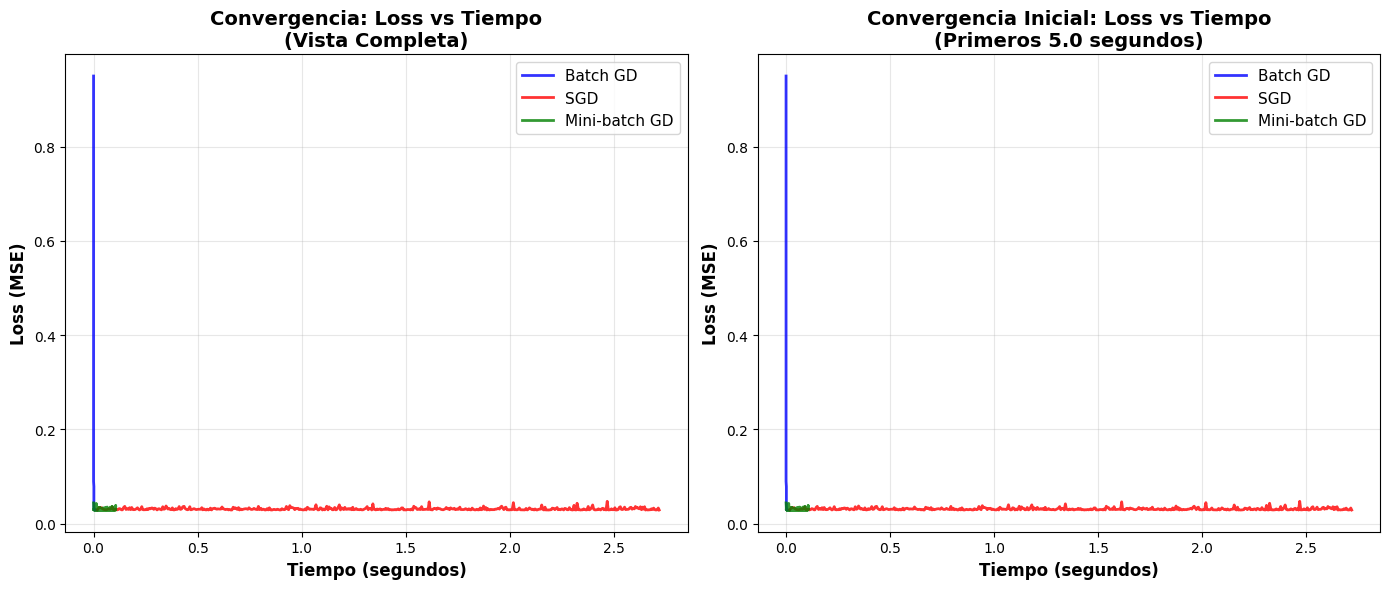

In [41]:
# Crear gráfica comparativa
plt.figure(figsize=(14, 6))

# Subplot 1: Convergencia completa
plt.subplot(1, 2, 1)
plt.plot(time_batch, loss_batch, 'b-', linewidth=2, label='Batch GD', alpha=0.8)
plt.plot(time_sgd, loss_sgd, 'r-', linewidth=2, label='SGD', alpha=0.8)
plt.plot(time_minibatch, loss_minibatch, 'g-', linewidth=2, label='Mini-batch GD', alpha=0.8)

plt.xlabel('Tiempo (segundos)', fontsize=12, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
plt.title('Convergencia: Loss vs Tiempo\n(Vista Completa)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Subplot 2: Zoom en los primeros segundos (convergencia inicial)
plt.subplot(1, 2, 2)
# Encontrar el índice donde cada algoritmo llega a ~5 segundos (o menos)
max_time_zoom = 5.0  # Primeros 5 segundos

# Filtrar datos para el zoom
idx_batch = [i for i, t in enumerate(time_batch) if t <= max_time_zoom]
idx_sgd = [i for i, t in enumerate(time_sgd) if t <= max_time_zoom]
idx_minibatch = [i for i, t in enumerate(time_minibatch) if t <= max_time_zoom]

if idx_batch:
    plt.plot([time_batch[i] for i in idx_batch], [loss_batch[i] for i in idx_batch], 
             'b-', linewidth=2, label='Batch GD', alpha=0.8)
if idx_sgd:
    plt.plot([time_sgd[i] for i in idx_sgd], [loss_sgd[i] for i in idx_sgd], 
             'r-', linewidth=2, label='SGD', alpha=0.8)
if idx_minibatch:
    plt.plot([time_minibatch[i] for i in idx_minibatch], [loss_minibatch[i] for i in idx_minibatch], 
             'g-', linewidth=2, label='Mini-batch GD', alpha=0.8)

plt.xlabel('Tiempo (segundos)', fontsize=12, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
plt.title(f'Convergencia Inicial: Loss vs Tiempo\n(Primeros {max_time_zoom} segundos)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [42]:
# Tabla comparativa de resultados
results_df = pd.DataFrame({
    'Algoritmo': ['Batch GD', 'SGD', 'Mini-batch GD'],
    'Loss Inicial': [loss_batch[0], loss_sgd[0], loss_minibatch[0]],
    'Loss Final': [loss_batch[-1], loss_sgd[-1], loss_minibatch[-1]],
    'Tiempo Total (s)': [time_batch[-1], time_sgd[-1], time_minibatch[-1]],
    'Tiempo/Época (s)': [
        time_batch[-1] / N_EPOCHS,
        time_sgd[-1] / N_EPOCHS,
        time_minibatch[-1] / N_EPOCHS
    ]
})

print(results_df.to_string(index=False))

    Algoritmo  Loss Inicial  Loss Final  Tiempo Total (s)  Tiempo/Época (s)
     Batch GD      0.949820    0.028871          0.016886          0.000034
          SGD      0.029218    0.028920          2.717944          0.005436
Mini-batch GD      0.043962    0.036890          0.106293          0.000213


### 3.c Conclusiones y Análisis

#### ¿Cuál método converge más rápido al principio?

El método que converge más rápido al inicio es Stochastic Gradient Descent (SGD), ya que realiza un gran número de actualizaciones en poco tiempo al usar una sola muestra por paso. Esto permite una reducción rápida del error en las primeras etapas del entrenamiento, aunque cada actualización se basa en un gradiente ruidoso. Mini-batch Gradient Descent presenta una velocidad inicial intermedia, mientras que Batch Gradient Descent es el más lento al comienzo debido a que realiza una única actualización por época y cada una requiere procesar todo el conjunto de datos,


#### ¿Cuál obtiene el error final más bajo y estable?

Batch Gradient Descent obtiene el error final más bajo y estable, ya que calcula el gradiente utilizando todos los datos, produciendo un descenso suave, determinístico y sin oscilaciones hacia el mínimo. Mini-batch Gradient Descent logra un error final cercano con pequeñas oscilaciones controladas, lo que representa un buen compromiso entre estabilidad y eficiencia computacional. En cambio, SGD presenta mayor variabilidad y oscilaciones persistentes alrededor del mínimo debido a la alta varianza del gradiente, lo que explica su menor estabilidad en el error final.

#### Justificación de los resultados observados

En este experimento usamos:
- Batch GD: η = 0.1
- Mini-batch GD: η = 0.05  
- SGD: η = 0.01

Razón: SGD con η = 0.1 causaba explosión de gradientes (overflow → NaN).


1. Diferencia en velocidad de convergencia:

La diferencia se debe al número de actualizaciones de pesos por unidad de tiempo:

- Batch GD: 1 actualización/época → ~1 actualización/segundo
- Mini-batch GD: ~31 actualizaciones/época → ~31 actualizaciones/segundo  
- SGD: 5000 actualizaciones/época → ~5000 actualizaciones/segundo

Aunque SGD hace gradientes ruidosos, la alta frecuencia compensa en las etapas iniciales.

2. Diferencia en estabilidad:

La estabilidad depende del tamaño de la muestra usada para estimar el gradiente:

```
Varianza del gradiente ∝ 1/batch_size
```

- Batch GD (N=1000): Varianza = 0
- Mini-batch (N=32): Varianza = 1/32 ≈ 0.03
- SGD (N=1): Varianza = 1

3. Por qué Mini-batch es el más usado en práctica:

-  Convergencia rápida (más actualizaciones que Batch)
-  Razonablemente estable (promedia varias muestras)
-  Eficiente en memoria y GPU (procesamiento paralelo)
-  Generaliza mejor (el ruido ayuda a escapar de mínimos locales)
-  Permite usar learning rates moderados (no tan pequeños como SGD)


# Task 2.2

1 Dataset: iris

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

# Cargar dataset Iris
iris = load_iris()
X = iris.data
y = iris.target


# Seleccionar solo 2 clases: Setosa 0, Versicolor 1
mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

# Seleccionar solo 2 features, sepal length y sepal width
X = X[:, [0, 1]]  # columnas 0 y 1

# Convertir clases a +1 y -1 (como vimos en clase)
# Setosa = -1, Versicolor = +1
y = np.where(y == 0, -1, 1)

print(f"Shape de X: {X.shape}")  # (100, 2)
print(f"Shape de y: {y.shape}")  # (100,)
print(f"Clases unicas: {np.unique(y)}")  # [-1, 1]
print(f"Primeras muestras:")
print(X[:5])
print(f"Primeras etiquetas:")
print(y[:5])

Shape de X: (100, 2)
Shape de y: (100,)
Clases unicas: [-1  1]
Primeras muestras:
[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]]
Primeras etiquetas:
[-1 -1 -1 -1 -1]


2 Implementación del Perceptrón

In [ ]:
# Perceptron para clasificacion binaria
class Perceptron:
    
    def __init__(self, learning_rate=0.01, n_epochs=100):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.w = None #pesos
        self.b = None #bias
        
    # Entrena el modelo
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Inicializar pesos y bias
        np.random.seed(42)
        self.w = np.random.randn(n_features) * 0.01
        self.b = 0.0
        
        print(f"\nPesos iniciales: w = {self.w}, b = {self.b}\n")
        
        # Bucle de entrenamiento
        for epoch in range(self.n_epochs):
            errors = 0
            
            for i in range(n_samples):
                x_i = X[i]
                y_i = y[i]
                
                # Calcular predicción (Forward pass)
                z = np.dot(self.w, x_i) + self.b
                y_pred = self._sign(z)
                
                # Calcular error y actualizar si es necesario
                error = y_i - y_pred
                
                if error != 0:
                    # Regla de actualizacion del perceptron
                    self.w += self.learning_rate * error * x_i
                    self.b += self.learning_rate * error
                    errors += 1
            
            # Mostrar progreso cada 10 epocas
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{self.n_epochs} - Errores: {errors}")
            
            # Detener si ya no hay errores
            if errors == 0:
                print(f"\nConvergencia alcanzada en epoch {epoch + 1}")
                break
        
        print(f"\nPesos finales: w = {self.w}, b = {self.b}")
    
    # Predecir nuevos datos
    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        return self._sign(z)
    
    # Fun de activacion signo
    def _sign(self, z):
        return np.where(z >= 0, 1, -1)

3 Visualización y Métricas 

In [46]:
# entrenar el modelo

perceptron = Perceptron(learning_rate=0.5, n_epochs=100)

print("ENTRENANDO PERCEPTRON")
perceptron.fit(X, y)

ENTRENANDO PERCEPTRON

Pesos iniciales: w = [ 0.00496714 -0.00138264], b = 0.0

Epoch 10/100 - Errores: 3
Epoch 20/100 - Errores: 2
Epoch 30/100 - Errores: 3
Epoch 40/100 - Errores: 2
Epoch 50/100 - Errores: 2
Epoch 60/100 - Errores: 3
Epoch 70/100 - Errores: 2
Epoch 80/100 - Errores: 2
Epoch 90/100 - Errores: 3
Epoch 100/100 - Errores: 2

Pesos finales: w = [ 40.70496714 -56.90138264], b = -24.0


In [48]:
# evaluar
y_pred = perceptron.predict(X)
accuracy = np.mean(y_pred == y)

print(f"Accuracy: {accuracy}")

Accuracy: 0.92


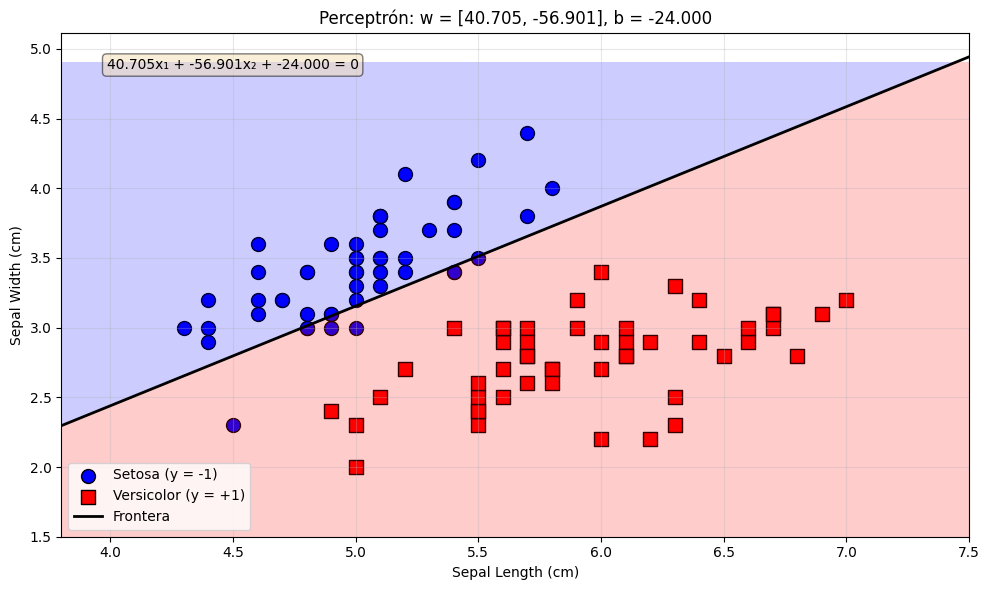

In [49]:
# Frontera de Decisión: Grafique los puntos de datos

def plot_decision_boundary(X, y, perceptron):
    plt.figure(figsize=(10, 6))
    
    # Graficar puntos de datos por clase
    X_class_neg = X[y == -1]  # Setosa
    X_class_pos = X[y == 1]   # Versicolor
    
    plt.scatter(X_class_neg[:, 0], X_class_neg[:, 1], 
                color='blue', marker='o', s=100, 
                label='Setosa (y = -1)', edgecolors='black')
    
    plt.scatter(X_class_pos[:, 0], X_class_pos[:, 1], 
                color='red', marker='s', s=100, 
                label='Versicolor (y = +1)', edgecolors='black')
    
    # Calcular y graficar la linea de la frontera w₁x₁ + w₂x₂ + b = 0
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x1_line = np.linspace(x1_min, x1_max, 100)
    
    # ec: x2 = -(w1/w2)x1 - (b/w2)
    w1, w2 = perceptron.w
    b = perceptron.b
    x2_line = -(w1 / w2) * x1_line - (b / w2)
    
    plt.plot(x1_line, x2_line, 'k-', linewidth=2, label='Frontera')
    
    # Sombrear las regiones de decisión
    x1_mesh = np.linspace(x1_min, x1_max, 300)
    x2_mesh = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 300)
    X1_mesh, X2_mesh = np.meshgrid(x1_mesh, x2_mesh)
    
    # Predecir sobre la malla de puntos
    X_mesh = np.c_[X1_mesh.ravel(), X2_mesh.ravel()]
    y_mesh = perceptron.predict(X_mesh).reshape(X1_mesh.shape)
    
    plt.contourf(X1_mesh, X2_mesh, y_mesh, alpha=0.2, 
                 levels=[-1, 0, 1], colors=['blue', 'red'])
    
    # Etiquetas y formato final
    plt.xlabel('Sepal Length (cm)')
    plt.ylabel('Sepal Width (cm)')
    plt.title(f'Perceptrón: w = [{w1:.3f}, {w2:.3f}], b = {b:.3f}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Mostrar la ec
    eq_text = f'{w1:.3f}x₁ + {w2:.3f}x₂ + {b:.3f} = 0'
    plt.text(0.05, 0.95, eq_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

plot_decision_boundary(X, y, perceptron)